In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import typing as tp
import yaml
import random
import os
import sys
import soundfile as sf
import librosa
import librosa.display
import cv2
import matplotlib.pyplot as plt
import time
import pickle
import glob
from tqdm import tqdm
import IPython.display
import seaborn as sns


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
# import resnest.torch as resnest_torch


pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
set_seed(777)

In [3]:
DATA_DIR = Path("/home/knikaido/work/BirdCLEF2021/data/")
MAIN_DATA_DIR = DATA_DIR / 'birdclef-2021'
DENOISE_DIR = DATA_DIR / 'birdclef-2021-denoise/train_short_audio'
OUTPUT_DIR = MAIN_DATA_DIR / 'birdclef-2021-melspectrogram'

In [4]:
######################
# Data #
######################
train_datadir = MAIN_DATA_DIR / 'train_short_audio'
train_csv = MAIN_DATA_DIR / 'train_metadata.csv'
train_soundscape = MAIN_DATA_DIR / 'train_soundscape_labels.csv'

output_train_datadir = OUTPUT_DIR / 'train_short_audio'

In [5]:
wav_path_list = sorted(glob.glob(str(train_datadir) + '/*/*.ogg')) 
len(wav_path_list)

62874

In [6]:
# denoise_wav_path_list = sorted(glob.glob(str(DENOISE_DIR) + '/*/*.ogg')) 
# len(denoise_wav_path_list)

In [7]:
train = pd.read_csv(MAIN_DATA_DIR / 'train_metadata.csv')
train

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62869,yetvir,[],"['adult', 'male', 'song']",30.2150,-97.6505,Vireo flavifrons,Yellow-throated Vireo,Caleb Helsel,2020-07-10,XC591680.ogg,Creative Commons Attribution-NonCommercial-Sha...,1.0,08:30,https://www.xeno-canto.org/591680
62870,yetvir,[],"['life stage uncertain', 'sex uncertain', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2019-05-31,XC600085.ogg,Creative Commons Attribution-NonCommercial-Sha...,5.0,09:30,https://www.xeno-canto.org/600085
62871,yetvir,"['amered', 'eawpew', 'norcar', 'reevir1']","['adult', 'male', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2020-06-02,XC602701.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.5,08:30,https://www.xeno-canto.org/602701
62872,yetvir,[],['uncertain'],32.2357,-99.8811,Vireo flavifrons,Yellow-throated Vireo,Brad Banner,2019-04-27,XC614733.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,17:30,https://www.xeno-canto.org/614733


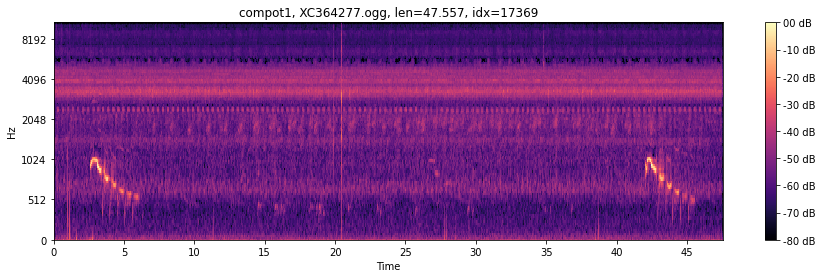

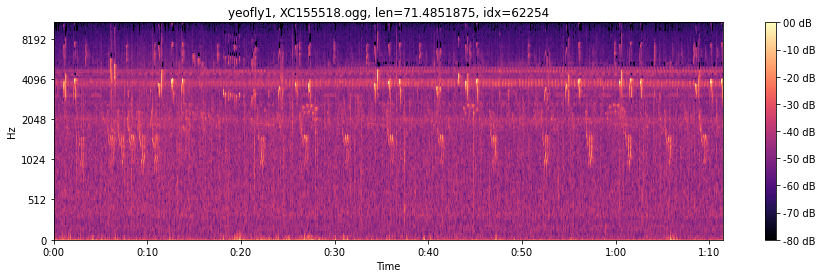

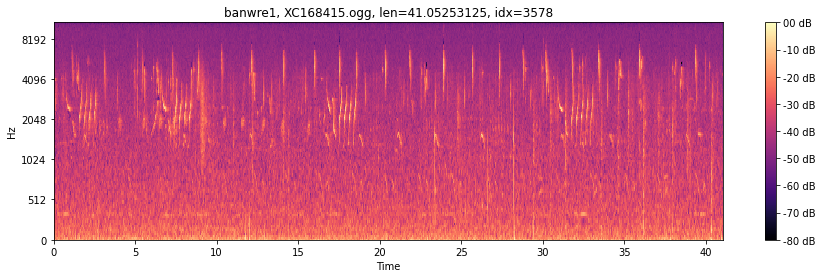

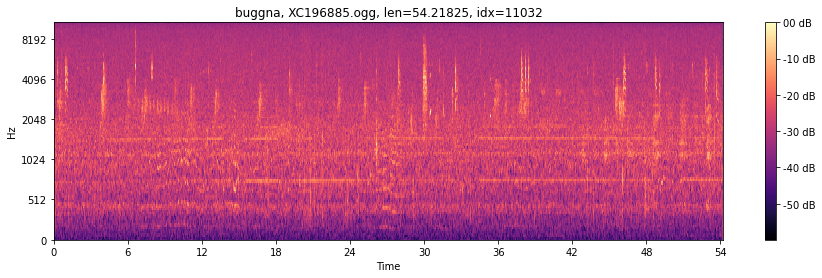

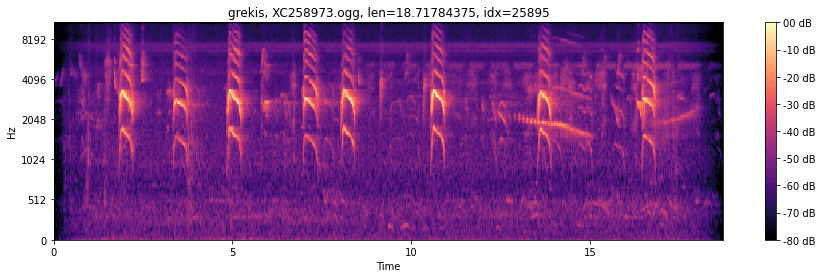

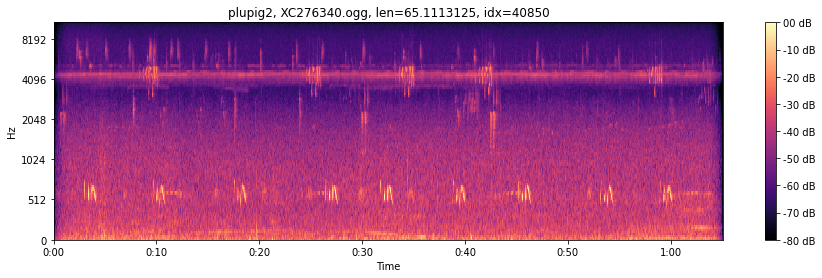

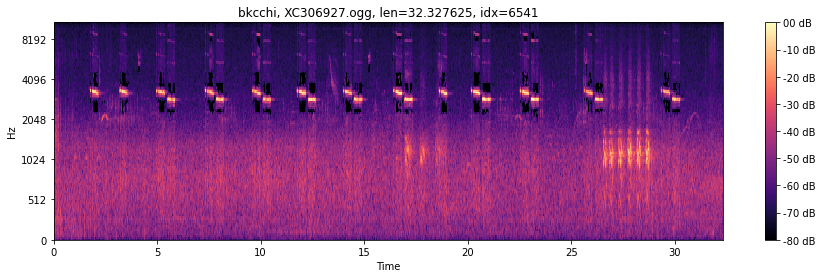

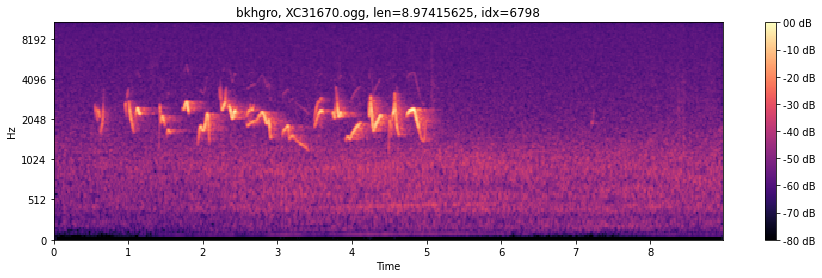

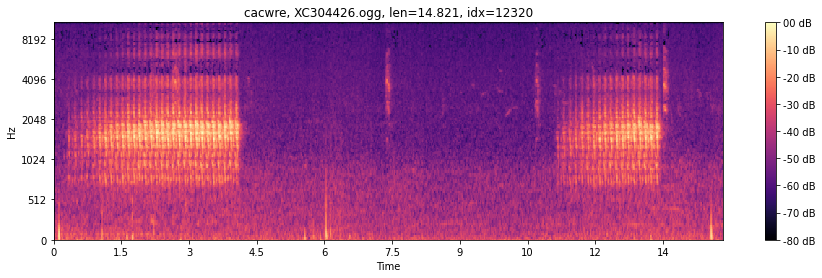

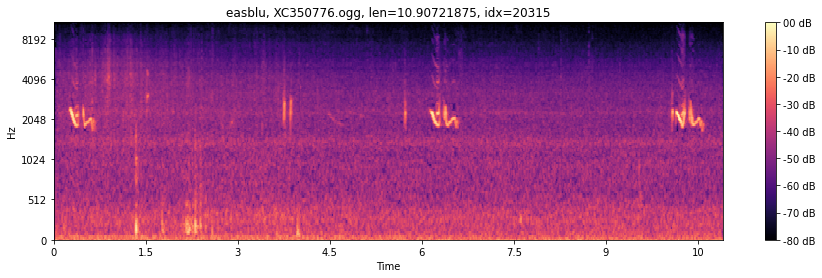

In [9]:
count = 0
while count < 10:
    idx = np.random.randint(len(train))
    raw = train.iloc[idx]

    wav_name = raw["filename"]
    ebird_code = raw["primary_label"]

    y, sr = sf.read(train_datadir / ebird_code / wav_name)

    melspec = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128,
                fmin=40, fmax=16000)
    melspec = librosa.power_to_db(np.abs(melspec), ref=np.max).astype(np.float32)

    plt.figure(figsize=(15,4))
    librosa.display.specshow(melspec, y_axis='mel', x_axis='time', sr=sr)
    plt.title(f'{ebird_code}, {wav_name}, len={len(y)/sr}, idx={idx}')
    plt.colorbar(format='%02.0f dB')
    
    count += 1
    

In [10]:
idx = 17369
raw = train.iloc[idx]
wav_name = raw["filename"]
ebird_code = raw["primary_label"]
IPython.display.Audio(train_datadir / ebird_code / wav_name)

## とりあえず全部出す

In [59]:
for idx in tqdm(range(len(train))):
    raw = train.iloc[idx]

    wav_name = raw["filename"]
    ebird_code = raw["primary_label"]

    y, sr = sf.read(train_datadir / ebird_code / wav_name)

    melspec = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128,
                fmin=40, fmax=16000)
    melspec = librosa.power_to_db(np.abs(melspec), ref=np.max).astype(np.float32)
    
    dir_ = output_train_datadir / ebird_code
    csv_name = wav_name.split('.')[0]
    if not os.path.isdir(dir_):
        os.makedirs(dir_)
        
    np.save(dir_/ csv_name, melspec)
    
#     plt.figure(figsize=(15,4))
#     librosa.display.specshow(melspec, y_axis='mel', x_axis='time', sr=sr)
#     plt.title(f'{ebird_code}, {wav_name}, len={melspec.shape[1]}, idx={idx}')
#     plt.colorbar(format='%02.0f dB')
    

100%|██████████| 62874/62874 [3:04:49<00:00,  5.67it/s]   
